## Monthly climatologies of biological variables in and out of polynyas in the sea ice zone of the Southern Ocean

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath

### Get the CESM2 4p4z tseries files 

In [2]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
variables = ['spC','coccoC','diatC','zoo1C','zoo2C','zoo3C','zoo4C',
             'x_graze_zoo1_zint','x_graze_zoo2_zint','x_graze_zoo3_zint','x_graze_zoo4_zint',
             'photoC_TOT_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint',
            'IFRAC']

In [3]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.006201-012212.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005
spC
coccoC
diatC
zoo1C
zoo2C
zoo3C
zoo4C
x_graze_zoo1_zint
x_graze_zoo2_zint
x_graze_zoo3_zint
x_graze_zoo4_zint
photoC_TOT_zint
photoC_diat_zint
photoC_sp_zint
photoC_cocco_zint
IFRAC
CPU times: user 7.74 s, sys: 433 ms, total: 8.18 s
Wall time: 10.9 s


In [4]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

### trim latitude

In [5]:
ds = ds.isel(nlat=slice(0,76))

### fix time bounds

In [6]:
#fix time dimension so it's a mean of the timebounds
ds["time"] = ds.time_bound.compute().mean(dim="d2")

### calculate 2-D fields & drop the 3-D ones

In [7]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['zooC_TOT_zint'] = ds['zoo1C_zint'] + ds['zoo2C_zint'] + ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.spC * 10.
ds['spC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.coccoC * 10.
ds['coccoC_zint'] = tmp.sum(dim='z_t_150m')

ds['phytoC_TOT_zint'] = ds['spC_zint'] + ds['diatC_zint'] + ds['coccoC_zint']

### get coords

In [8]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
ds_grid = ds_grid.isel(nlat=slice(0,76))
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4

ds['z_t']=ds_grid.z_t
depths_m=ds_grid.z_t * 0.01
dz=ds_grid.dz
dz_m=ds_grid.dz * 0.01
tlen=len(ds.time)

### a bit of housekeeping

In [9]:
ds = ds.drop(['spC','coccoC','diatC','zoo1C','zoo2C','zoo3C','zoo4C'])
ds  = ds.drop(['z_t','z_t_150m'])
ds  = ds.where(ds_grid.REGION_MASK>0)

In [10]:
#redefine variable list
variables = ['phytoC_TOT_zint','zooC_TOT_zint'] # 'spC_zint','coccoC_zint','diatC_zint','zoo1C_zint','zoo2C_zint','zoo3C_zint','zoo4C_zint',
             #'x_graze_zoo1_zint','x_graze_zoo2_zint','x_graze_zoo3_zint','x_graze_zoo4_zint',
             #'photoC_TOT_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint',
            #'IFRAC','phytoC_TOT_zint','zooC_TOT_zint']

### Get polynya masks 

#### 0 = not a polynya
#### 1 = open water polynya
#### 2 = coastal polynya


In [27]:
# thres_var='aice'
# thres = '25%'

# thres_var='hi'
# thres = '0.8m'

thres_var='hi'
thres = '0.22m'

path = '/glade/p/cesm/pcwg/landrum/' + case + '/ice/polynyas/monthly/'

In [28]:
file = path + case + '.' + thres_var + '_' + thres + 'thresh.polynya_sh.006201-012212.nc'

ds_poly = xr.open_dataset(file, drop_variables=["transport_components", "transport_regions"], decode_times=True)

### a bit more housekeeping

In [29]:
ds_poly = ds_poly.rename({'lon': 'nlon','lat': 'nlat'})

In [30]:
ds_poly['time'] = ds.time

In [31]:
ds['polynyas'] = ds_poly['polynyas']

### make timeseries in the polynyas

In [32]:
%%time
ts_nonpolynas = xr.Dataset({v: ds[v] for v in ['time']})
ts_openpolynas = xr.Dataset({v: ds[v] for v in ['time']})
ts_coastalpolynas = xr.Dataset({v: ds[v] for v in ['time']})


for var in variables:
    
    print('doing var ',var)
    
    masked = ds[var].where(ds.polynyas==0.).where(ds.IFRAC>0.15)
    ts_nonpolynas[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ds[var].where(ds.polynyas==1.)
    ts_openpolynas[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ds[var].where(ds.polynyas==2.)
    ts_coastalpolynas[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    


doing var  phytoC_TOT_zint
doing var  zooC_TOT_zint
CPU times: user 8min 18s, sys: 1min 4s, total: 9min 23s
Wall time: 11min 19s


### Make monthly climatology 

In [33]:
clim_nonpolynas = ts_nonpolynas.groupby('time.month').mean('time')
clim_openpolynas = ts_openpolynas.groupby('time.month').mean('time')
clim_coastalpolynas = ts_coastalpolynas.groupby('time.month').mean('time')

In [34]:
clim_nonpolynas = xr.concat([clim_nonpolynas,clim_nonpolynas.isel(month=slice(0,6))],dim='month')
clim_openpolynas = xr.concat([clim_openpolynas,clim_openpolynas.isel(month=slice(0,6))],dim='month')
clim_coastalpolynas = xr.concat([clim_coastalpolynas,clim_coastalpolynas.isel(month=slice(0,6))],dim='month')

In [35]:
clim_openpolynas.phytoC_TOT_zint

<xarray.DataArray 'phytoC_TOT_zint' (month: 18)>
array([253.69326538, 378.12133551, 165.47579002,  52.27513094,
        20.70880508,   7.8909359 ,          nan,  15.01668704,
        12.47145638,          nan, 116.52259646, 229.82914336,
       253.69326538, 378.12133551, 165.47579002,  52.27513094,
        20.70880508,   7.8909359 ])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6
Attributes:
    long_name:     Small Phyto Carbon
    units:         mmol/m^3
    grid_loc:      3114
    cell_methods:  time: mean

In [36]:
xlabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']
xvals = np.arange(1,19,1)

### Plot shifts in phytplankton biomass

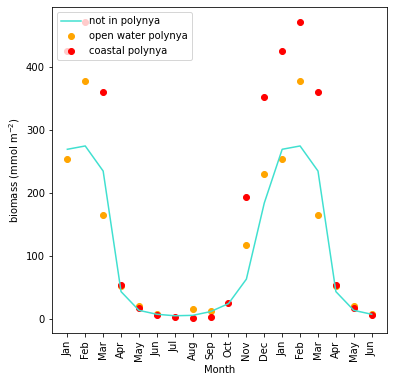

In [37]:
fig = plt.figure(figsize=(6,6))

ax1 = fig.add_subplot(1,1,1)
ax1.set_ylabel('biomass (mmol m$^{-2}$)')
ax1.set_xlabel('Month')

var='phytoC_TOT_zint'

#plot mesozoo in non-polynyas
ax1.plot(xvals,clim_nonpolynas[var], 
         color='turquoise', label='not in polynya')

#plot mesozoo in open water polynyas
ax1.scatter(xvals,clim_openpolynas[var], 
         color='orange', label='open water polynya')

#plot 2090s
ax1.scatter(xvals,clim_coastalpolynas[var], 
         color='red', label='coastal polynya')

ax1.legend(loc='upper left')

plt.xticks(xvals, xlabels, rotation='vertical');


### with this threshold
thres_var='hi'
thres = '0.8m'

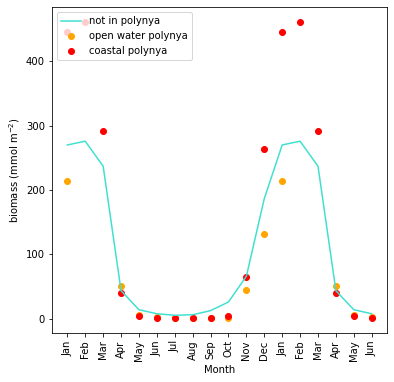

In [26]:
fig = plt.figure(figsize=(6,6))

ax1 = fig.add_subplot(1,1,1)
ax1.set_ylabel('biomass (mmol m$^{-2}$)')
ax1.set_xlabel('Month')

var='phytoC_TOT_zint'

#plot mesozoo in non-polynyas
ax1.plot(xvals,clim_nonpolynas[var], 
         color='turquoise', label='not in polynya')

#plot mesozoo in open water polynyas
ax1.scatter(xvals,clim_openpolynas[var], 
         color='orange', label='open water polynya')

#plot 2090s
ax1.scatter(xvals,clim_coastalpolynas[var], 
         color='red', label='coastal polynya')

ax1.legend(loc='upper left')

plt.xticks(xvals, xlabels, rotation='vertical');
